In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import gammy
from gammy.arraymapper import x
from gammy.models.bayespy import GAM

In [3]:
X_train = pd.read_csv("data/X_train.csv")
X_test = pd.read_csv("data/X_test.csv")
y_train = pd.read_csv("data/y_train.csv")
y_test = pd.read_csv("data/y_test.csv")

## Perform PCA

In [4]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Find the most important features
most_important_features = np.argmax(np.abs(pca.components_), axis=1)
print("Most important features:", X_train.columns[most_important_features])

Most important features: Index(['3', '9'], dtype='object')


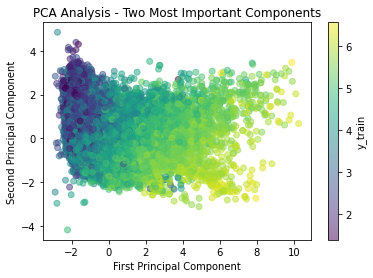

In [5]:
# Plot the PCA components
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.iloc[:, 0], cmap='viridis', alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='y_train')
plt.title('PCA Analysis - Two Most Important Components')
plt.show()

In [6]:
print(X_train_pca.shape)
print(X_test_pca.shape)

y_train = np.array(y_train).reshape(-1)
print(y_train.shape)
y_test = np.array(y_test).reshape(-1)
print(y_test.shape)

(22270, 2)
(9545, 2)
(22270,)
(9545,)


In [7]:
final_result = pd.DataFrame(columns=["Model", "Train MSE", "Train MAE", "Test MSE", "Test MAE"])

## Linear Regression

In [8]:
# Perform linear regression
lr = LinearRegression()
lr.fit(X_train_pca, y_train)

# Make predictions
y_train_pred = lr.predict(X_train_pca)
y_test_pred = lr.predict(X_test_pca)

# Calculate MSE and MAE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("MSE Train:", mse_train)
print("MSE Test:", mse_test)
print("MAE Train:", mae_train)
print("MAE Test:", mae_test)

final_result = final_result.append({"Model": "Linear Regression", "Train MSE": mse_train, "Train MAE": mae_train, "Test MSE": mse_test, "Test MAE": mae_test}, ignore_index=True)

MSE Train: 0.4231712879213379
MSE Test: 0.4314427661175174
MAE Train: 0.5150273500513582
MAE Test: 0.5206119321868021


<ipython-input-8-c9b8ce87a504>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_result = final_result.append({"Model": "Linear Regression", "Train MSE": mse_train, "Train MAE": mae_train, "Test MSE": mse_test, "Test MAE": mae_test}, ignore_index=True)


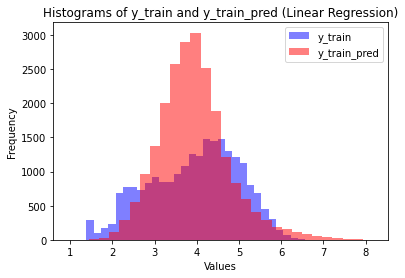

In [10]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Linear Regression)')
plt.savefig("model/train-linear.pdf", format="pdf", bbox_inches="tight")
plt.show()

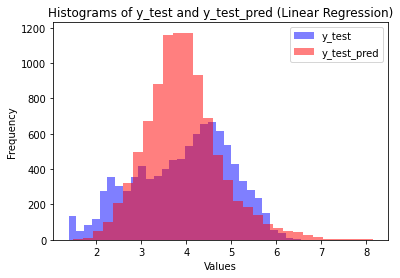

In [11]:
plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Linear Regression)')
plt.savefig("model/test-linear.pdf", format="pdf", bbox_inches="tight")
plt.show()

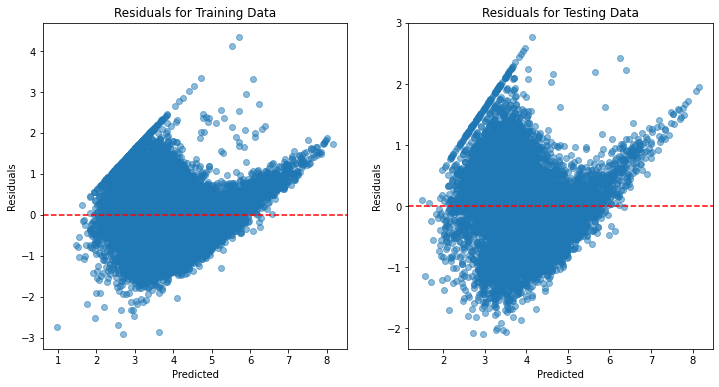

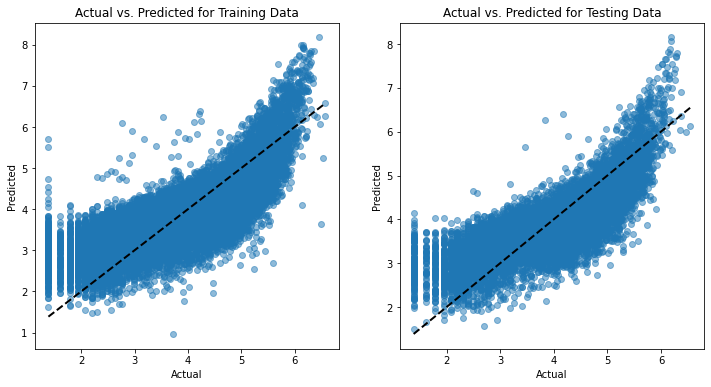

In [12]:
# Plot residuals for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred.ravel(), y_train_pred.ravel() - y_train, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals for Training Data')

# Plot residuals for testing data
plt.subplot(1, 2, 2)
plt.scatter(y_test_pred.ravel(), y_test_pred.ravel() - y_test, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals for Testing Data')
plt.show()

# Plot actual vs. predicted for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred.ravel(), alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted for Training Data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)

# Plot actual vs. predicted for testing data
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred.ravel(), alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted for Testing Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()


## Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

def rf_optimization(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               random_state=42)
    rf.fit(X_train_pca, y_train)
    y_pred = rf.predict(X_test_pca)
    mse = mean_squared_error(y_test, y_pred)
    
    return -mse

bounds = {
    'n_estimators': (10, 200),
    'max_depth': (1, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

optimizer = BayesianOptimization(f=rf_optimization, pbounds=bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

best_params_bayes = optimizer.max['params']
best_params_bayes['n_estimators'] = int(best_params_bayes['n_estimators'])
best_params_bayes['max_depth'] = int(best_params_bayes['max_depth'])
best_params_bayes['min_samples_split'] = int(best_params_bayes['min_samples_split'])
best_params_bayes['min_samples_leaf'] = int(best_params_bayes['min_samples_leaf'])

print("Best Parameters for Random Forest (Bayesian Optimization):", best_params_bayes)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.3948   | 11.86     | 3.852     | 7.856     | 123.7     |
| 2         | -0.3913   | 5.525     | 1.468     | 2.465     | 174.6     |
| 3         | -0.4183   | 18.43     | 3.124     | 2.165     | 194.3     |
| 4         | -0.4482   | 25.14     | 1.637     | 3.455     | 44.85     |
| 5         | -0.3896   | 9.823     | 2.574     | 5.456     | 65.33     |
| 6         | -0.3919   | 10.27     | 1.594     | 5.349     | 64.5      |
| 7         | -0.4415   | 3.612     | 1.0       | 6.587     | 82.21     |
| 8         | -0.6748   | 1.0       | 4.0       | 9.105     | 60.36     |
| 9         | -0.411    | 15.75     | 2.335     | 2.923     | 69.5      |
| 10        | -0.3922   | 10.8      | 2.152     | 2.407     | 182.6     |
| 11        | -0.674    | 1.0       | 1.0       | 4.724     | 183.3     |
| 12        | -0.3984   | 12.45     | 

In [ ]:
# Train and evaluate the best model
best_rf = RandomForestRegressor(**best_params_bayes, random_state=42)
best_rf.fit(X_train_pca, y_train)

y_train_pred_rf = best_rf.predict(X_train_pca)
y_test_pred_rf = best_rf.predict(X_test_pca)

mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)

print("Random Forest (Bayesian Optimization) MSE Train:", mse_train_rf)
print("Random Forest (Bayesian Optimization) MSE Test:", mse_test_rf)
print("Random Forest (Bayesian Optimization) MAE Train:", mae_train_rf)
print("Random Forest (Bayesian Optimization) MAE Test:", mae_test_rf)

## append to final_result
final_result = final_result.append({"Model": "Random Forest", "Train MSE": mse_train_rf, "Train MAE": mae_train_rf, "Test MSE": mse_test_rf, "Test MAE": mae_test_rf}, ignore_index=True)

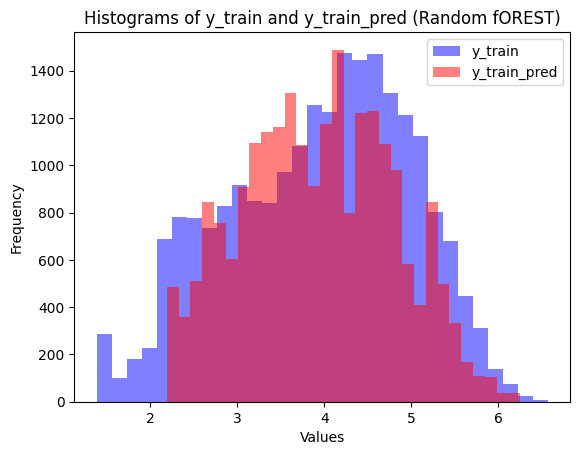

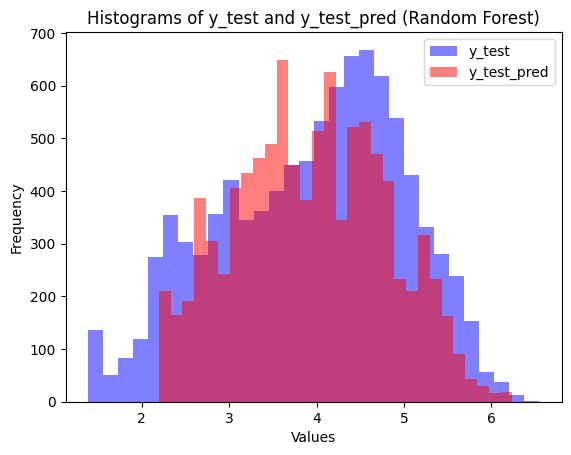

In [9]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred_rf, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Random fOREST)')
plt.savefig("model/train-RF.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred_rf, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Random Forest)')
plt.savefig("model/test-RF.pdf", format="pdf", bbox_inches="tight")
plt.show()


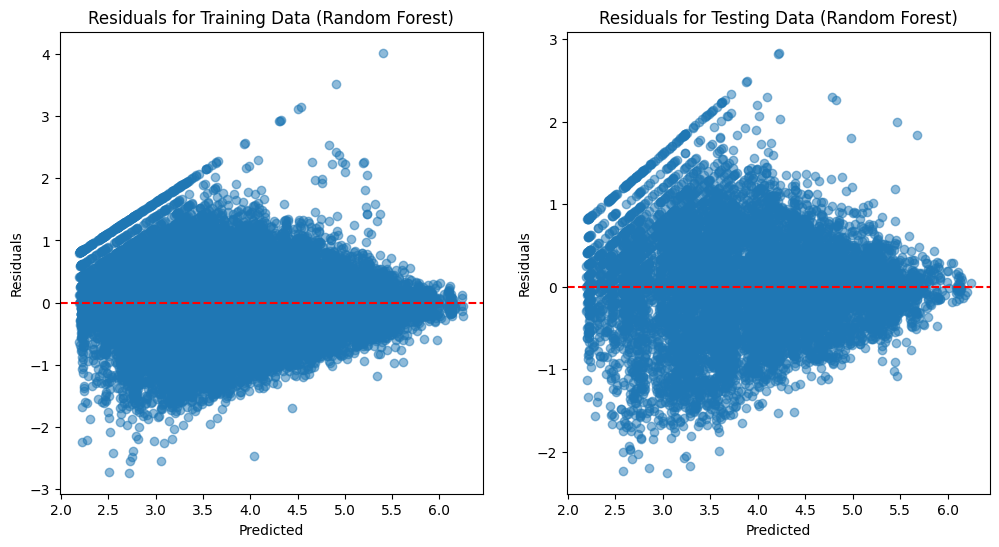

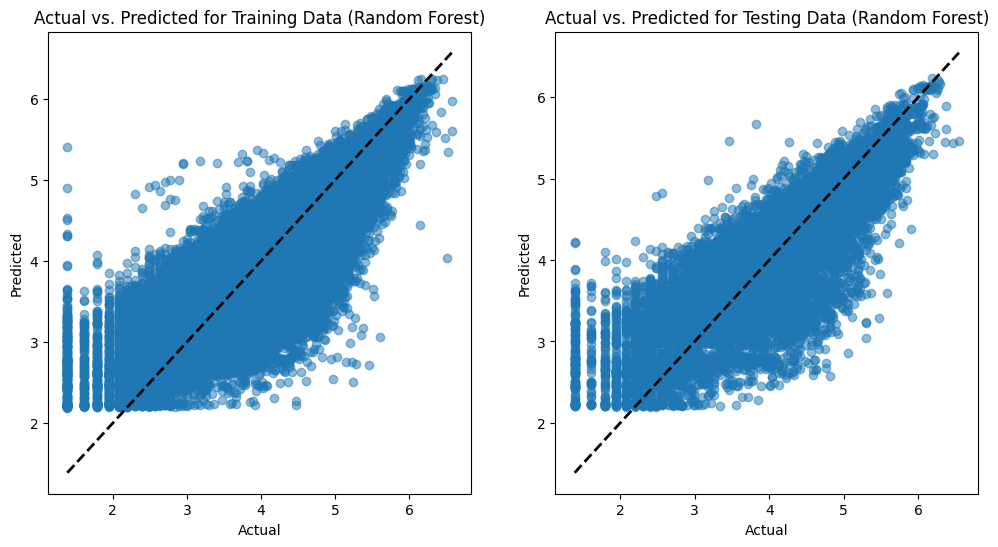

In [13]:
# Plot residuals for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred_rf, y_train_pred_rf - y_train, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals for Training Data (Random Forest)')

# Plot residuals for testing data
plt.subplot(1, 2, 2)
plt.scatter(y_test_pred_rf, y_test_pred_rf - y_test, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals for Testing Data (Random Forest)')
plt.show()

# Plot actual vs. predicted for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_rf, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted for Training Data (Random Forest)')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)

# Plot actual vs. predicted for testing data
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rf, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted for Testing Data (Random Forest)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

## Linear GAM

In [10]:
from pygam import LinearGAM, s, l

# Define the model with splines for each variable
gam = LinearGAM(s(0) + s(1)).fit(X_train_pca, y_train)

lams = np.logspace(-3, 3, 10)
gam.gridsearch(X_train_pca, y_train, lam=lams)

y_train_pred_gam = gam.predict(X_train_pca)
mse_train_gam = mean_squared_error(y_train, y_train_pred_gam)
mae_train_gam = mean_absolute_error(y_train, y_train_pred_gam)

y_test_pred_gam = gam.predict(X_test_pca)
mse_test_gam = mean_squared_error(y_test, y_test_pred_gam)
mae_test_gam = mean_absolute_error(y_test, y_test_pred_gam)

print("Training Results (Linear GAM):")
print("Mean Squared Error:", mse_train_gam)
print("Mean Absolute Error:", mae_train_gam)

print("\nTesting Results (Linear GAM):")
print("Mean Squared Error:", mse_test_gam)
print("Mean Absolute Error:", mae_test_gam)

## append to final_result
final_result = final_result.append({"Model": "Frequentist Penalized GAM", "Train MSE": mse_train_gam, "Train MAE": mae_train_gam, "Test MSE": mse_test_gam, "Test MAE": mae_test_gam}, ignore_index=True)

100% (10 of 10) |########################| Elapsed Time: 0:00:11 Time:  0:00:11
Training Results (Linear GAM):
Mean Squared Error: 0.38323102053656327
Mean Absolute Error: 0.48148072847209894

Testing Results (Linear GAM):
Mean Squared Error: 0.3901355313489805
Mean Absolute Error: 0.48672398223023655


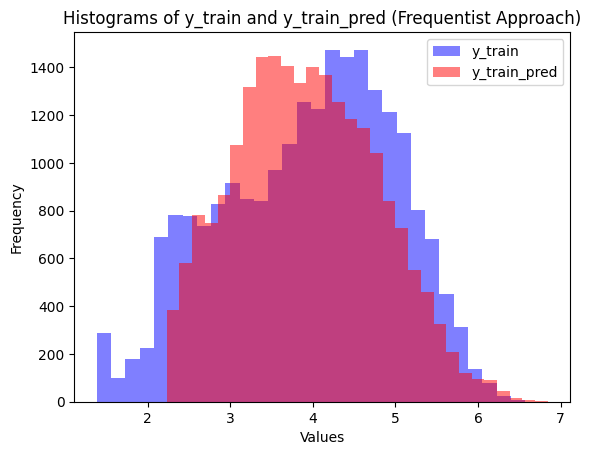

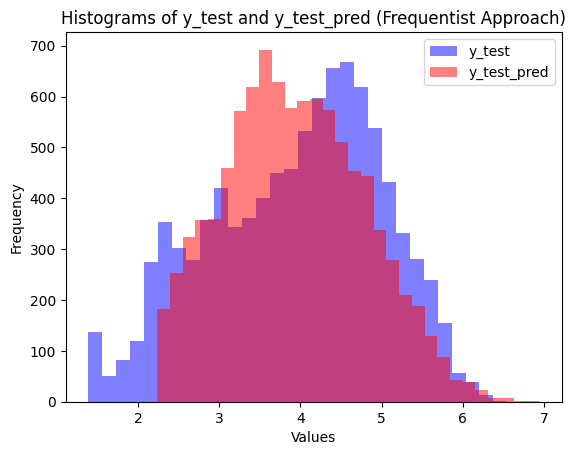

In [11]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred_gam, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Frequentist Approach)')
plt.savefig("model/train-gam.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred_gam, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Frequentist Approach)')
plt.savefig("model/test-gam.pdf", format="pdf", bbox_inches="tight")
plt.show()

## GAMMY

In [16]:
a = gammy.ExpSquared1d(
    np.arange(-4, 10, 0.1),
    corrlen=0.5,
    sigma=4.0,
    energy=0.9
)(x[:, 0])
b = gammy.ExpSquared1d(
    np.arange(-4, 10, 0.1),
    corrlen=0.5,
    sigma=4.0,
    energy=0.9
)(x[:, 1])
A = gammy.Kron(a, b)
bias = gammy.Scalar()
formula = A + bias

model = gammy.models.bayespy.GAM(formula).fit(X_train_pca, y_train)


In [17]:
y_train_pred_gammy1 = model.predict(X_train_pca)
mse_train_gam = mean_squared_error(y_train, y_train_pred_gammy1)
mae_train_gam = mean_absolute_error(y_train, y_train_pred_gammy1)

y_test_pred_gammy1 = model.predict(X_test_pca)
mse_test_gam = mean_squared_error(y_test, y_test_pred_gammy1)
mae_test_gam = mean_absolute_error(y_test, y_test_pred_gammy1)

print("Training Results (Gammy with Exp-Squared):")
print("Mean Squared Error:", mse_train_gam)
print("Mean Absolute Error:", mae_train_gam)

print("\nTesting Results (Gammy with Exp-Squared):")
print("Mean Squared Error:", mse_test_gam)
print("Mean Absolute Error:", mae_test_gam)

## append to final_result
final_result = final_result.append({"Model": "Gaussian Process Prior (Exp-Squared)", "Train MSE": mse_train_gam, "Train MAE": mae_train_gam, "Test MSE": mse_test_gam, "Test MAE": mae_test_gam}, ignore_index=True)

Training Results (Gammy with Exp-Squared):
Mean Squared Error: 0.3740806269051756
Mean Absolute Error: 0.47191316920399173

Testing Results (Gammy with Exp-Squared):
Mean Squared Error: 0.3844590305603691
Mean Absolute Error: 0.4798603082697516


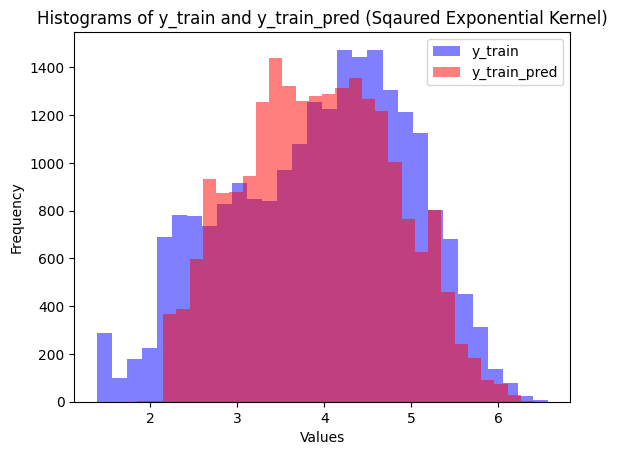

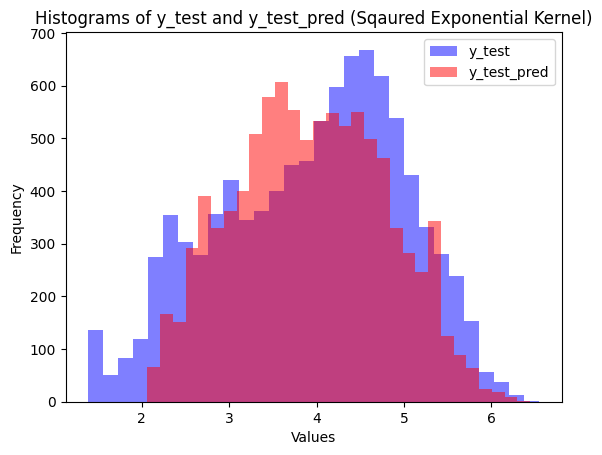

In [18]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred_gammy1, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Sqaured Exponential Kernel)')
plt.savefig("model/train-gp-exp.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred_gammy1, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Sqaured Exponential Kernel)')
plt.savefig("model/test-gp-exp.pdf", format="pdf", bbox_inches="tight")
plt.show()

### GAMMY with Rational Quadratic Kernel

In [19]:
a = gammy.RationalQuadratic1d(
    np.arange(-4, 10, 0.1),
    corrlen=0.5,
    alpha=1,
    sigma=4.0,
    energy=0.9
)(x[:, 0])
b = gammy.RationalQuadratic1d(
    np.arange(-4, 10, 0.1),
    corrlen=0.5,
    alpha=1,
    sigma=4.0,
    energy=0.9
)(x[:, 1])
A = gammy.Kron(a, b)
bias = gammy.Scalar()
formula = A + bias

model = gammy.models.bayespy.GAM(formula).fit(X_train_pca, y_train)

In [20]:
y_train_pred_gammy2 = model.predict(X_train_pca)
mse_train_gam = mean_squared_error(y_train, y_train_pred_gammy2)
mae_train_gam = mean_absolute_error(y_train, y_train_pred_gammy2)

y_test_pred_gammy2 = model.predict(X_test_pca)
mse_test_gam = mean_squared_error(y_test, y_test_pred_gammy2)
mae_test_gam = mean_absolute_error(y_test, y_test_pred_gammy2)

print("Training Results (Gammy with Rational Quadratic):")
print("Mean Squared Error:", mse_train_gam)
print("Mean Absolute Error:", mae_train_gam)

print("\nTesting Results (Gammy with Rational Quadratic):")
print("Mean Squared Error:", mse_test_gam)
print("Mean Absolute Error:", mae_test_gam)

## append to final_result
final_result = final_result.append({"Model": "Gaussian Process Prior (Rational Quadratic)", "Train MSE": mse_train_gam, "Train MAE": mae_train_gam, "Test MSE": mse_test_gam, "Test MAE": mae_test_gam}, ignore_index=True)

Training Results (Gammy with Rational Quadratic):
Mean Squared Error: 0.37431601005310744
Mean Absolute Error: 0.4720877391269375

Testing Results (Gammy with Rational Quadratic):
Mean Squared Error: 0.3842139623196041
Mean Absolute Error: 0.47958024199940824


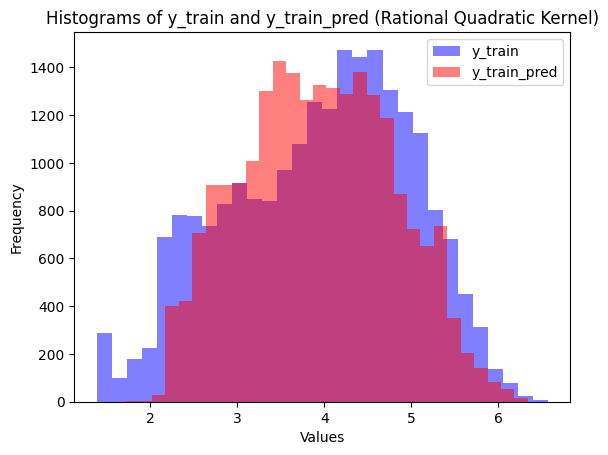

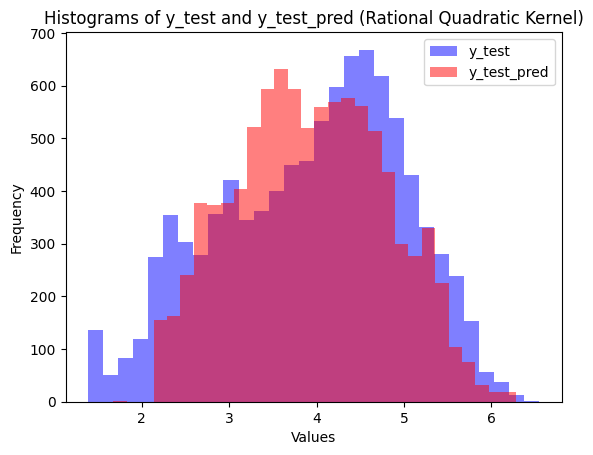

In [21]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred_gammy2, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Rational Quadratic Kernel)')
plt.savefig("model/train-gp-rq.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred_gammy2, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Rational Quadratic Kernel)')
plt.savefig("model/test-gp-rq.pdf", format="pdf", bbox_inches="tight")
plt.show()

### GAMMY with Orn Uhl

In [22]:
import gammy
from gammy.arraymapper import x
from gammy.models.bayespy import GAM

a = gammy.OrnsteinUhlenbeck1d(
    np.arange(-4, 10, 0.5),
    corrlen=0.5,
    sigma=4.0,
    energy=0.9
)(x[:, 0])
b = gammy.OrnsteinUhlenbeck1d(
    np.arange(-4, 10, 0.5),
    corrlen=0.5,
    sigma=4.0,
    energy=0.9
)(x[:, 1])
A = gammy.Kron(a, b)
formula = A 

orn_uhl_model = gammy.models.bayespy.GAM(formula).fit(X_train_pca, y_train)


In [23]:
y_train_pred_gammy3 = orn_uhl_model.predict(X_train_pca)
mse_train_gam = mean_squared_error(y_train, y_train_pred_gammy3)
mae_train_gam = mean_absolute_error(y_train, y_train_pred_gammy3)

y_test_pred_gammy3 = orn_uhl_model.predict(X_test_pca)
mse_test_gam = mean_squared_error(y_test, y_test_pred_gammy3)
mae_test_gam = mean_absolute_error(y_test, y_test_pred_gammy3)

print("Training Results (Gammy with Rational Quadratic):")
print("Mean Squared Error:", mse_train_gam)
print("Mean Absolute Error:", mae_train_gam)

print("\nTesting Results (Gammy with Rational Quadratic):")
print("Mean Squared Error:", mse_test_gam)
print("Mean Absolute Error:", mae_test_gam)

## append to final_result
final_result = final_result.append({"Model": "Gaussian Process Prior (Ornstein Uhlenbeck)", "Train MSE": mse_train_gam, "Train MAE": mae_train_gam, "Test MSE": mse_test_gam, "Test MAE": mae_test_gam}, ignore_index=True)

Training Results (Gammy with Rational Quadratic):
Mean Squared Error: 0.3729454048086831
Mean Absolute Error: 0.4709652576886531

Testing Results (Gammy with Rational Quadratic):
Mean Squared Error: 0.3877005181457355
Mean Absolute Error: 0.48095166029913655


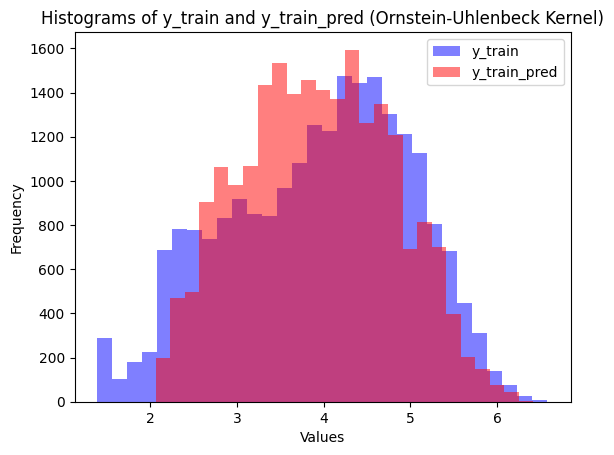

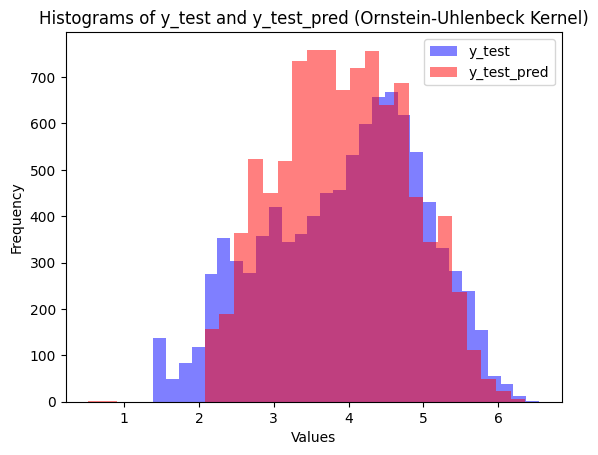

In [24]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred_gammy3, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Ornstein-Uhlenbeck Kernel)')
plt.savefig("model/train-gp-orn.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred_gammy3, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Ornstein-Uhlenbeck Kernel)')
plt.savefig("model/test-gp-orn.pdf", format="pdf", bbox_inches="tight")
plt.show()